### Required Libraries python

In [1]:
import os
import random
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import splitfolders

from IPython.display import display
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import ConfusionMatrixDisplay

### Explore the COVID-19 radiography dataset

In [2]:
# Print the subdirectories of the dataset
DATASET_PATH = './covid-19_radiography_dataset'

dir_list = os.listdir(DATASET_PATH)
print(dir_list)

['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


In [3]:
# Print the number of images per subdirectory
num_of_images = []
for root, dirs, files in os.walk(DATASET_PATH):
    if root == DATASET_PATH: continue
    print('{}: {}'.format(os.path.basename(root), len(files)))
    num_of_images.append(len(files))

COVID: 3616
Lung Opacity: 6012
Normal: 10192
Viral Pneumonia: 1345


path: C:\Users\Thy\Downloads\attention-based-CNNs\covid-19_radiography_dataset\COVID\COVID-2542.png
size: (299, 299)
mode: L
format: PNG


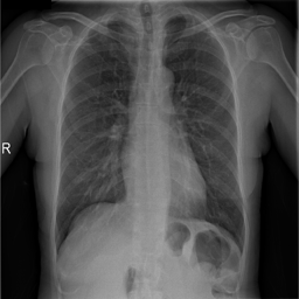

In [4]:
# Display a random image and print its path, size, mode, and format
SEED = 123
random.seed(SEED)
rand_img = Image.open(random.choice(glob(DATASET_PATH + '/**/*')))

print('path:', rand_img.filename)
print('size:', rand_img.size)
print('mode:', rand_img.mode)
print('format:', rand_img.format)
display(rand_img)

### Visualize the COVID-19 radiography dataset

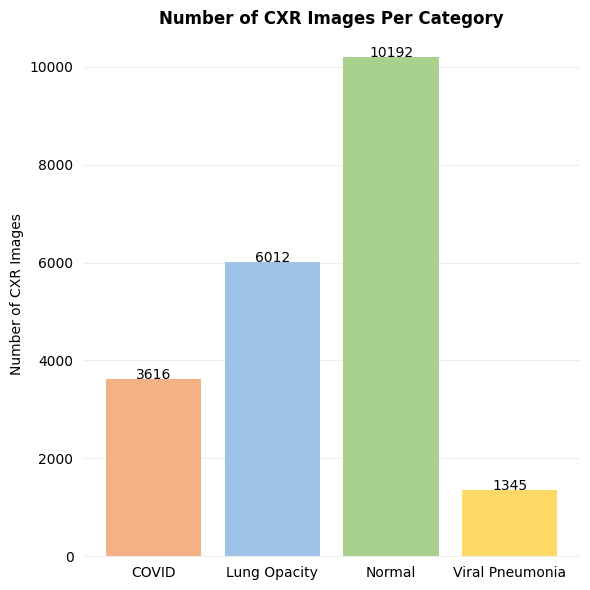

In [5]:
# Plot the number of images per subdirectory
x_coord = np.arange(len(dir_list))
colors = ['#f4b183', '#9dc3e6', '#a9d18e', '#ffd966']

fig, ax = plt.subplots(facecolor='white', figsize=(6,6))
ax.bar(x_coord, num_of_images, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#EEEEEE')

ax.yaxis.grid(True, color='#EEEEEE')
ax.set_axisbelow(True)

plt.xticks(x_coord, dir_list)
ax.tick_params(bottom=False, left=False)

plt.title('Number of CXR Images Per Category', fontweight='bold')
plt.ylabel('Number of CXR Images')

for i in range(len(x_coord)):
    plt.text(i, num_of_images[i], num_of_images[i], ha='center')

plt.tight_layout()
plt.savefig('./figures/bar_chart.png', dpi=200)
plt.show()

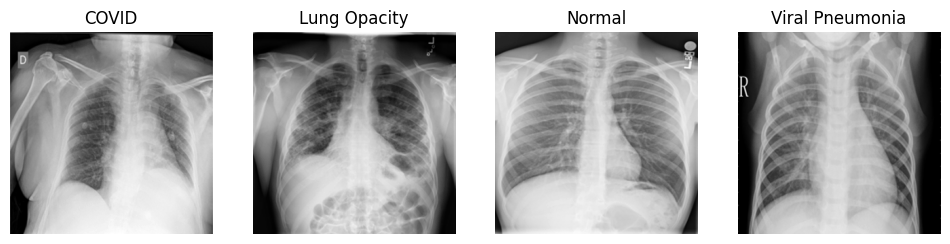

In [6]:
# Display random images, one from each category
plt.figure(facecolor='white', figsize=(12,3))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    path = random.choice(glob(DATASET_PATH + '/' + dir_list[i] + '/*'))
    plt.imshow(Image.open(path), cmap='gray')
    plt.title(dir_list[i])
    plt.axis('off')
plt.savefig('figures/random_images.png', dpi=200)
plt.show()

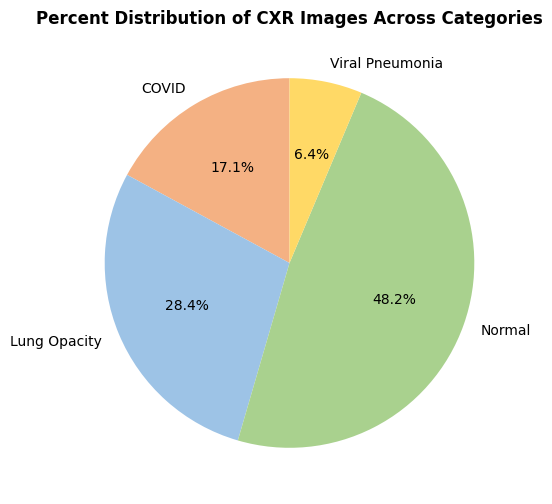

In [7]:
# Plot the percent distribution of images across subdirectories
plt.figure(facecolor='white', figsize=(6,6))
plt.pie(num_of_images,
        labels=dir_list,
        colors=colors,
        autopct='%.1f%%',
        startangle=90)
plt.title('Percent Distribution of CXR Images Across Categories', fontweight='bold')
plt.savefig('./figures/pie_chart.png', dpi=200)
plt.show()

### Preprocess the COVID-19 radiography dataset

In [8]:
# Check categories
dir_list = os.listdir(DATASET_PATH)
print("Dataset categories:", dir_list)

Dataset categories: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


In [9]:
# Count number of images in each category
num_of_images = []
for category in dir_list:
    category_path = os.path.join(DATASET_PATH, category)
    num_of_images.append(len(os.listdir(category_path)))
    print(f"{category}: {len(os.listdir(category_path))} images")


COVID: 3616 images
Lung Opacity: 6012 images
Normal: 10192 images
Viral Pneumonia: 1345 images


In [10]:
# Split dataset into train, validation, and test sets
OUTPUT_PATH = 'dataset_subsets'

if not os.path.exists(OUTPUT_PATH):
    splitfolders.ratio(DATASET_PATH, OUTPUT_PATH, seed=42, ratio=(0.7, 0.1, 0.2))

In [11]:
# Define image parameters
IMG_DIMS = 224
TARGET_SIZE = (IMG_DIMS, IMG_DIMS)
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
CLASS_MODE = 'categorical'

In [12]:
# Define dataset directories
TRAIN_PATH = os.path.join(OUTPUT_PATH, 'train')
VALID_PATH = os.path.join(OUTPUT_PATH, 'val')
TEST_PATH = os.path.join(OUTPUT_PATH, 'test')

In [13]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True
)

In [14]:
# No augmentation for validation and test sets, just rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Load datasets
train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, seed=42)

val_gen = val_test_datagen.flow_from_directory(
    VALID_PATH, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, seed=42)

test_gen = val_test_datagen.flow_from_directory(
    TEST_PATH, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, shuffle=False)

Found 14814 images belonging to 4 classes.
Found 2115 images belonging to 4 classes.
Found 4236 images belonging to 4 classes.


### Build the AttentionCNN Model

In [16]:
# Define the Attention mechanism
def AttentionBlock(inputs):
    """
    Implements the attention mechanism to highlight important features.
    
    Args:
        inputs (tensor): Input feature map.
    
    Returns:
        tensor: Attention-weighted feature map.
    """
    attention = layers.Conv2D(64, kernel_size=1, activation='relu')(inputs)  # Extract key features
    attention = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(attention)  # Generate attention map
    return layers.multiply([inputs, attention])  # Apply attention weights


In [17]:
# Define Convolutional Feature Extractor
def ConvBlock(x, filters):
    """
    A convolutional block with Conv2D, ReLU activation, and MaxPooling.
    
    Args:
        x (tensor): Input tensor.
        filters (int): Number of filters in Conv layer.
    
    Returns:
        tensor: Output feature map.
    """
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)  # Feature extraction
    x = layers.MaxPooling2D((2, 2))(x)  # Reduce spatial dimensions
    return x

In [18]:
# Define the AttentionCNN model
def build_attention_cnn(input_shape, num_classes):
    """
    Builds an Attention-based CNN model for pneumonia detection.

    Args:
        input_shape (tuple): Shape of input images (Height, Width, Channels).
        num_classes (int): Number of output classes.

    Returns:
        keras.Model: Compiled CNN model with attention mechanism.
    """
    
    # 1. Input Layer
    inputs = layers.Input(shape=input_shape)

    # 2. Convolutional Feature Extraction
    x = ConvBlock(inputs, filters=64)  # Extract low-level features
    x = ConvBlock(x, filters=128)  # Extract deeper patterns

    # 3. Attention Mechanism (Highlights important lung regions)
    x = AttentionBlock(x)

    # 4. Additional Feature Extraction
    x = ConvBlock(x, filters=256)  # Extract complex patterns

    # 5. Fully Connected Layers (Classification)
    x = layers.Flatten()(x)  # Convert feature maps to a 1D vector
    x = layers.Dense(256, activation='relu')(x)  # Learn high-level patterns
    x = layers.Dropout(0.5)(x)  # Prevent overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Classification output

    # 6. Create and return the model
    model = models.Model(inputs, outputs, name="Attention_CNN")
    return model

In [19]:
# Build the AttentionCNN model
model = build_attention_cnn(input_shape=(224, 224, 3), num_classes=len(dir_list))

In [20]:
# Compile the model with loss and optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Display model architecture
model.summary()

Model: "Attention_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │      8,256 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56, 1) │         65 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ multiply[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 200704)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 51,380,480 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,760,645 (197.45 MB)

 Trainable params: 51,760,645 (197.45 MB)

 Non-trainable params: 0 (0.00 B)

### Train the AttentionCNN model

In [22]:
EPOCHS = 25

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/25


c:\Users\Thy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/463 ━━━━━━━━━━━━━━━━━━━━ 1623s 3s/step - accuracy: 0.5367 - loss: 1.1159 - val_accuracy: 0.6723 - val_loss: 0.7591
Epoch 2/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1490s 3s/step - accuracy: 0.6803 - loss: 0.7822 - val_accuracy: 0.7343 - val_loss: 0.6545
Epoch 3/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1491s 3s/step - accuracy: 0.7067 - loss: 0.7091 - val_accuracy: 0.7830 - val_loss: 0.5691
Epoch 4/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1488s 3s/step - accuracy: 0.7396 - loss: 0.6426 - val_accuracy: 0.7972 - val_loss: 0.5399
Epoch 5/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1490s 3s/step - accuracy: 0.7679 - loss: 0.5942 - val_accuracy: 0.7882 - val_loss: 0.5398
Epoch 6/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1486s 3s/step - accuracy: 0.7915 - loss: 0.5449 - val_accuracy: 0.8331 - val_loss: 0.4555
Epoch 7/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1484s 3s/step - accuracy: 0.8058 - loss: 0.5168 - val_accuracy: 0.8350 - val_loss: 0.4208
Epoch 8/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 1486s 3s/step - accuracy: 0.8183 - loss: 0.4846 - val_accurac

### Visualize the training results

In [23]:
def plot_metric_history(metric, val_metric, y_label, title):
    """
    Plots a training history metric.

    :param metric: the metric key
    :param val_metric: the validation metric key
    :param y_label: the y-axis label
    :param title: the title
    :return: None
    """
    plt.figure(facecolor='white', figsize=(8, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['training', 'validation'])
    plt.savefig('./figures/' + y_label + '.png', dpi=200)
    plt.show()

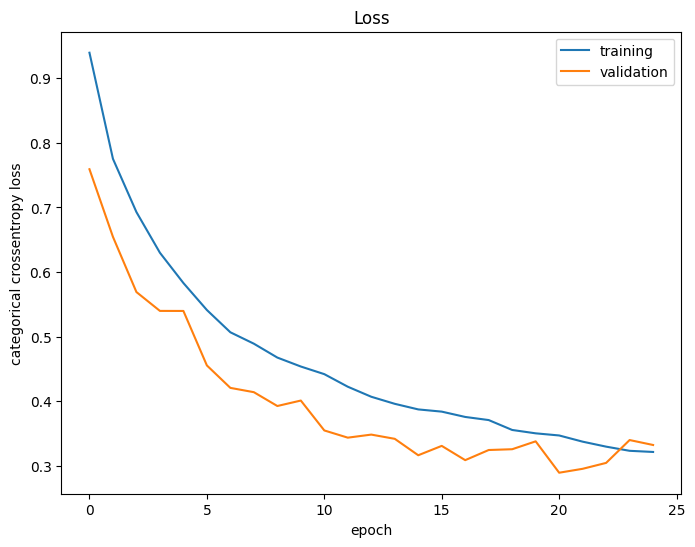

In [24]:
# Visualize loss history
plot_metric_history(metric='loss',
                    val_metric='val_loss',
                    y_label='categorical crossentropy loss',
                    title='Loss')

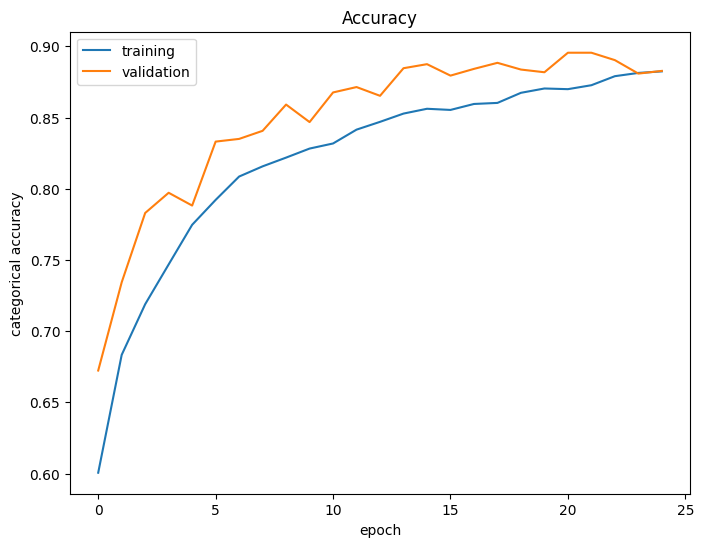

In [25]:
# Visualize accuracy history
plot_metric_history(metric='accuracy',
                    val_metric='val_accuracy',
                    y_label='categorical accuracy',
                    title='Accuracy')

### Evaluate the model

In [26]:
# Accuracy
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

c:\Users\Thy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/133 ━━━━━━━━━━━━━━━━━━━━ 124s 939ms/step - accuracy: 0.8563 - loss: 0.4014
Test Accuracy: 0.8921


In [27]:
# Generate predictions
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step
                 precision    recall  f1-score   support

          COVID       0.98      0.86      0.91       724
   Lung Opacity       0.91      0.78      0.84      1203
         Normal       0.85      0.97      0.90      2039
Viral Pneumonia       0.98      0.90      0.94       270

       accuracy                           0.89      4236
      macro avg       0.93      0.88      0.90      4236
   weighted avg       0.90      0.89      0.89      4236



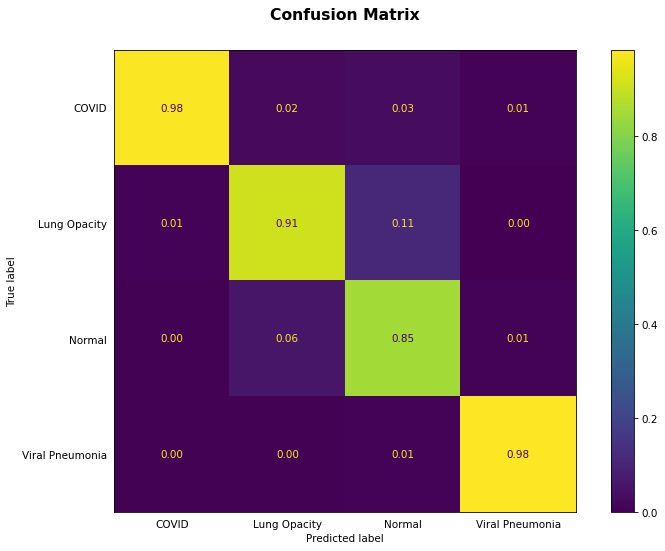

In [28]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes, normalize='pred')

# Create a figure and axis for Confusion Matrix Display
fig, ax = plt.subplots(facecolor='white', figsize=(12, 8), dpi=75)

# Generate the confusion matrix plot
ConfusionMatrixDisplay.from_predictions(true_classes,
                                        predicted_classes,
                                        display_labels=class_labels,
                                        include_values=True,
                                        normalize='pred',
                                        values_format='.2f',
                                        cmap='viridis',
                                        ax=ax)

# Improve visualization
plt.tick_params(left=False, bottom=False)
plt.title('Confusion Matrix', fontsize=15, fontweight='bold', pad=30)

# Save figure
plt.savefig('figures/confusion_matrix.png', dpi=200)

# Show the plot
plt.show()

### Save the Model

In [30]:
model.save("./figures/attention_cnn_pneumonia.h5")